In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

from torchvision import transforms

%matplotlib inline

In [8]:
env = gym.make("Pong-v0")

In [9]:
obs = env.reset()
env.render()

In [4]:
obs.shape

(210, 160, 3)

In [5]:
obs.copy()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ..., 
       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,

In [27]:
env.reset()
for _ in trange(1000):
    obs, reward, done, info = env.step(4)
    env.render()

 30%|██▉       | 296/1000 [00:04<00:11, 59.99it/s]


KeyboardInterrupt: 

In [28]:
info

{'ale.lives': 0}

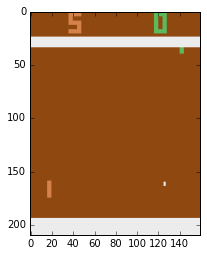

In [29]:
plt.imshow(obs)

In [30]:
tensor = torch.from_numpy(obs.transpose((2, 0, 1)))

In [66]:
resize = transforms.Compose([transforms.ToPILImage(),transforms.Scale(size=40),transforms.ToTensor()])

def preprocess(obs):
    tensor = torch.from_numpy(obs.transpose((2, 0, 1)))
    resized = resize(tensor)
    return resized.unsqueeze(0)

In [67]:
img = resize(tensor).numpy()

In [33]:
img.shape

(3, 52, 40)

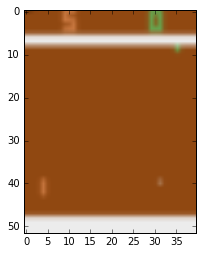

In [34]:
plt.imshow(img.transpose(1,2,0))

In [38]:
env.action_space.n

6

In [73]:
if torch.cuda.is_available():
    def to_var(x, requires_grad=False, gpu=None):
        x = x.cuda(gpu)
        return Variable(x, requires_grad=requires_grad)
else:
    def to_var(x, requires_grad=False, vgpu=None):
        return Variable(x, requires_grad=requires_grad)
    
def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)

In [54]:
img_v = to_var(resize(tensor).unsqueeze(0))

In [55]:
class Net(nn.Module):
    def __init__(self, action_n):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(3,32,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(32,128,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(128,32,kernel_size=5),nn.ReLU(),nn.AdaptiveMaxPool2d(output_size=1))
        self.fc = nn.Linear(32, action_n)
        
    def forward(self, x):
        feat = self.conv(x)
        logit = self.fc(feat.view(feat.size(0),-1))
        return logit

In [56]:
net = Net(env.action_space.n)
if torch.cuda.is_available():
    net = net.cuda()

In [57]:
net(img_v)

Variable containing:
 0.0481  0.0790 -0.0447 -0.0849 -0.0010  0.1625
[torch.FloatTensor of size 1x6]

In [82]:
class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99, running_start=0,
#                 episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): # eploration will start after 150 episodes
                 episode2thresh=lambda i: 0): # without exploration
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = running_start
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train()
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.eval()
        state = to_var(preprocess(obs))
        prob = self.model(state)
        _, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = to_var(preprocess(obs))
    logits = model(state)
    probs = F.softmax(logits, dim=1)
    m = Categorical(probs)
    if np.random.random()>thresh:
#         print(probs)
        try:
            action = m.sample()
        except:
            print(probs,m)
            raise
    else:
        action_space = probs.size(1)
        action = to_var(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = to_var(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [86]:
net = Net(env.action_space.n)
if torch.cuda.is_available():
    net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3,weight_decay=0.001)
trainer = PolicyGradient(model=net,running_start=-21)
writer = SummaryWriter()

In [84]:
trainer.greedy_policy(obs)

3

In [90]:
for episode in range(10000):
    last_frame = frame = env.reset()
    obs = frame-last_frame
    total_reward = 0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.select_action(obs)
        frame, reward, done, _ = trainer.take_action(action, env, render=False)
        obs = frame-last_frame
        last_frame=frame
        total_reward+=reward
        if done:
             break
    policy_loss = trainer.get_loss_and_clear()
    writer.add_scalar("loss",policy_loss.data[0],episode)
    writer.add_scalar("reward",total_reward,episode)
#     print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    clip_grads(trainer.model,-5,5)
    optimizer.step()
    running_reward = trainer.running_reward
    print(episode, total_reward,running_reward)
    if running_reward>1:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

0 -21.0 -21.0
1 -19.0 -20.98
2 -20.0 -20.9702
3 -18.0 -20.940497999999998
4 -21.0 -20.94109302
5 -21.0 -20.9416820898
6 -19.0 -20.922265268902002
7 -21.0 -20.92304261621298
8 -20.0 -20.91381219005085
9 -21.0 -20.914674068150344
10 -21.0 -20.91552732746884
11 -20.0 -20.90637205419415
12 -20.0 -20.89730833365221
13 -21.0 -20.898335250315686
14 -19.0 -20.87935189781253
15 -20.0 -20.870558378834403
16 -20.0 -20.861852795046058
17 -20.0 -20.853234267095598
18 -19.0 -20.834701924424643
19 -19.0 -20.816354905180397
20 -21.0 -20.818191356128594
21 -20.0 -20.810009442567306
22 -21.0 -20.811909348141633
23 -21.0 -20.813790254660216
24 -20.0 -20.80565235211361
25 -20.0 -20.797595828592474
26 -21.0 -20.79961987030655
27 -21.0 -20.801623671603487
28 -21.0 -20.803607434887454
29 -21.0 -20.80557136053858
30 -20.0 -20.797515646933192
31 -19.0 -20.779540490463862
32 -20.0 -20.77174508555922
33 -19.0 -20.75402763470363
34 -20.0 -20.746487358356593
35 -21.0 -20.74902248477303
36 -21.0 -20.7515322599253
3


KeyboardInterrupt



In [89]:
type(policy_loss.data[0])

float